In [61]:
import numpy as np
import pandas as pd
from datetime import date
from random import seed
from random import random

import time
import scipy, scipy.signal
import os, os.path
import shutil
import matplotlib
import matplotlib.pyplot as plt

from pylab import imshow

# vgg16 model used for transfer learning on the dogs and cats dataset
from matplotlib import pyplot
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf
# from keras.optimizers import SGD

from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# from keras.optimizers import gradient_descent_v2
# SGD = gradient_descent_v2.SGD(...)

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


import h5py
import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [43]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [3]:
idx = "EVI"
train_folder = '//Users/hn/Documents/01_research_data/NASA/ML_data/train_images_' + idx + '/'
test_folder = "/Users/hn/Documents/01_research_data/NASA/ML_data/limitCrops_nonExpert_images/"

# Prepare final dataset

In [4]:
# organize dataset into a useful structure
# create directories
dataset_home = train_folder

# create label subdirectories
labeldirs = ['separate_singleDouble/single/', 'separate_singleDouble/double/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    os.makedirs(newdir, exist_ok=True)
    
# copy training dataset images into subdirectories
for file in os.listdir(train_folder):
    src = train_folder + '/' + file
    if file.startswith('single'):
        dst = dataset_home + 'separate_singleDouble/single/'  + file
        shutil.copyfile(src, dst)
    elif file.startswith('double'):
        dst = dataset_home + 'separate_singleDouble/double/'  + file
        shutil.copyfile(src, dst)

# Plot For Fun

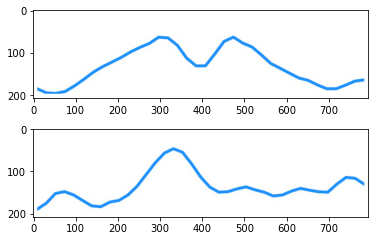

In [7]:
# plot dog photos from the dogs vs cats dataset
from matplotlib.image import imread


# define location of dataset
# plot first few images
files = os.listdir(train_folder)[2:4]
# files = [sorted(os.listdir(train_folder))[2]] + [sorted(os.listdir(train_folder))[-2]]
for i in range(2):
    # define subplot
    pyplot.subplot(210 + 1 + i)
    # define filename
    filename = train_folder + files[i]
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

# Full Code

In [66]:
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    _model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_separate_dir = train_folder + "separate_singleDouble/"
    train_it = datagen.flow_from_directory(train_separate_dir,
                                           class_mode='binary', 
                                           batch_size=16, 
                                           target_size=(224, 224))
    # fit model
    _model.fit(train_it, 
           steps_per_epoch=len(train_it), 
           epochs=10, verbose=1)
    
    model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
    
    _model.save(model_dir+'01_TL_SingleDouble.h5')
#     tf.keras.models.save_model(model=trained_model, filepath=model_dir+'01_TL_SingleDouble.h5')
  
#     return(_model)

# entry point, run the test harness
start_time = time.time()
run_test_harness()
end_time = time.time()

Found 434 images belonging to 2 classes.
Epoch 1/10
28/28 [==============================] - 28s 975ms/step - loss: 4.5334 - accuracy: 0.7765
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 0.1865 - accuracy: 0.9355
Epoch 3/10
28/28 [==============================] - 42s 1s/step - loss: 0.1167 - accuracy: 0.9585
Epoch 4/10
28/28 [==============================] - 33s 1s/step - loss: 0.0580 - accuracy: 0.9793
Epoch 5/10
28/28 [==============================] - 30s 1s/step - loss: 0.0381 - accuracy: 0.9839
Epoch 6/10
28/28 [==============================] - 32s 1s/step - loss: 0.0482 - accuracy: 0.9816
Epoch 7/10
28/28 [==============================] - 31s 1s/step - loss: 0.0356 - accuracy: 0.9885
Epoch 8/10
28/28 [==============================] - 36s 1s/step - loss: 0.0753 - accuracy: 0.9700
Epoch 9/10
28/28 [==============================] - 31s 1s/step - loss: 0.0416 - accuracy: 0.9885
Epoch 10/10
28/28 [==============================] - 33s 1s/step - loss: 0

In [33]:
# photo = load_img(train_folder + files[0], target_size=(200, 500))
# photo

# Make Prediction

In [74]:
model = load_model(model_dir + '01_TL_SingleDouble.h5')

probability of being single cropped is [0.00012851].


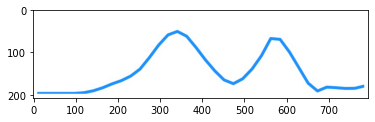

In [173]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# # load an image and predict the class
# def run_example():
#     # load the image
#     test_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/limitCrops_nonExpert_images_EVI/"
#     img = load_image(test_dir+'double_101682_WSDA_SF_2018.jpg')
#     # load model
#     model_dir = "/Users/hn/Documents/01_research_data/NASA/ML_Models/"
#     model = load_model(model_dir + '01_TL_SingleDouble.h5')
#     # predict the class
#     result = model.predict(img)
#     print(result[0])

# entry point, run the example
# run_example()


file_name = 'double_101163_WSDA_SF_2017.jpg'
test_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/limitCrops_nonExpert_images_EVI/"
img = load_image(test_dir+file_name)
result = model.predict(img)
print ("probability of being single cropped is {}.".format(result[0]))

pyplot.subplot(111)
# define filename
filename = img
image = imread(test_dir+file_name)
pyplot.imshow(image)
pyplot.show()

# Test Phase

In [196]:
test_dir = "/Users/hn/Documents/01_research_data/NASA/ML_data/limitCrops_nonExpert_images_EVI/"

test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_df["human_predict"] = test_df.filename.str.split("_", expand=True)[0]
test_df["prob_single"]=-1.0
test_df.head(2)

,filename,human_predict,prob_single
0,single_99791_WSDA_SF_2017.jpg,single,-1.0
1,single_6776_WSDA_SF_2016.jpg,single,-1.0


In [197]:
# test_datagen = ImageDataGenerator(featurewise_center=True)
# Image_Size = (224, 224)
# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=Image_Size)

In [198]:
model = load_model(model_dir + '01_TL_SingleDouble.h5')

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [199]:
for idx in test_df.index:
    img = load_image(test_dir + test_df.loc[idx, 'filename'])
    test_df.loc[idx, 'prob_single'] = model.predict(img)[0][0]

In [206]:
test_df.loc[40:50]

,filename,human_predict,prob_single
40,single_6315_WSDA_SF_2016.jpg,single,1.000000
41,single_44419_WSDA_SF_2018.jpg,single,0.999954
42,double_188071_WSDA_SF_2015.jpg,double,0.999870
43,single_5263_WSDA_SF_2016.jpg,single,0.999953
44,single_108436_WSDA_SF_2017.jpg,single,1.000000
45,single_104834_WSDA_SF_2017.jpg,single,0.994884
46,single_5480_WSDA_SF_2016.jpg,single,0.998545
47,double_46371_WSDA_SF_2018.jpg,double,0.000003
48,double_102912_WSDA_SF_2018.jpg,double,1.000000
49,single_100122_WSDA_SF_2017.jpg,single,0.992123


In [69]:
# pip show keras
# pip list --outdated
# !pip3 install --upgrade keras